In [ ]:
import pandas as pd
import matplotlib.pyplot as plt



In [ ]:
# Load the dataset
from zipfile import ZipFile
import requests
from io import BytesIO
zip_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"

response = requests.get(zip_url)
with ZipFile(BytesIO(response.content)) as z:

    with z.open('day.csv') as f:
        df = pd.read_csv(f)


#1. How do temperatures change across the seasons? What are the mean and median temperatures?


In [ ]:
df['dteday'] = pd.to_datetime(df['dteday'])



In [ ]:
df['month'] = df['dteday'].dt.month
df['season'] = df['season'].map({1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'})



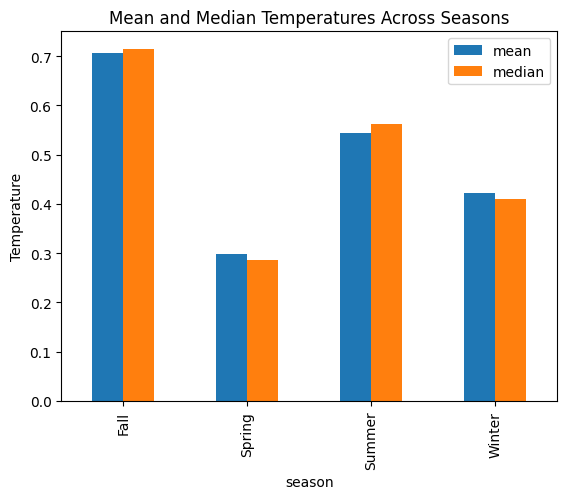

In [ ]:
# Plot mean and median temperatures across seasons
seasonal_temps = df.groupby('season')['temp'].agg(['mean', 'median'])
seasonal_temps.plot(kind='bar', ylabel='Temperature', title='Mean and Median Temperatures Across Seasons')
plt.show()

#2. Is there a correlation between temp/atemp/mean.temp.atemp and the total count of bike rentals?

In [ ]:
correlation_matrix = df[['temp', 'atemp', 'hum', 'windspeed', 'cnt']].corr()

print(correlation_matrix)

               temp     atemp       hum  windspeed       cnt
temp       1.000000  0.991702  0.126963  -0.157944  0.627494
atemp      0.991702  1.000000  0.139988  -0.183643  0.631066
hum        0.126963  0.139988  1.000000  -0.248489 -0.100659
windspeed -0.157944 -0.183643 -0.248489   1.000000 -0.234545
cnt        0.627494  0.631066 -0.100659  -0.234545  1.000000


#3. What are the mean temperature, humidity, windspeed, and total rentals per month?

In [ ]:
monthly_stats = df.groupby('month')['temp', 'hum', 'windspeed', 'cnt'].mean()

print(monthly_stats)

           temp       hum  windspeed          cnt
month                                            
1      0.236444  0.585828   0.206303  2176.338710
2      0.299226  0.567465   0.215684  2655.298246
3      0.390539  0.588475   0.222699  3692.258065
4      0.469999  0.588063   0.234482  4484.900000
5      0.594798  0.688958   0.182989  5349.774194
6      0.684097  0.575806   0.185420  5772.366667
7      0.755470  0.597876   0.166059  5563.677419
8      0.708582  0.637730   0.172918  5664.419355
9      0.616485  0.714714   0.165945  5766.516667
10     0.485012  0.693761   0.175205  5199.225806
11     0.369220  0.624876   0.183801  4247.183333
12     0.324031  0.666041   0.176609  3403.806452


<ipython-input-7-79a76cee1615>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  monthly_stats = df.groupby('month')['temp', 'hum', 'windspeed', 'cnt'].mean()


#4. Is temperature associated with bike rentals (registered vs. casual)?

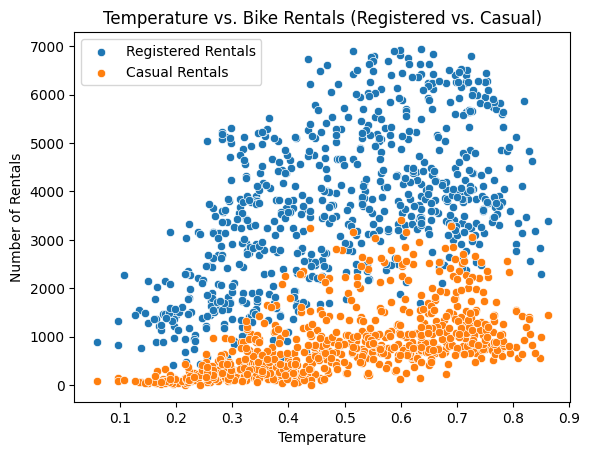

In [ ]:
import seaborn as sns

sns.scatterplot(x='temp', y='registered', data=df, label='Registered Rentals')
sns.scatterplot(x='temp', y='casual', data=df, label='Casual Rentals')
plt.xlabel('Temperature')
plt.ylabel('Number of Rentals')
plt.title('Temperature vs. Bike Rentals (Registered vs. Casual)')
plt.legend()
plt.show()

#Plot cnt vs dteday and examine its patterns and irregularities

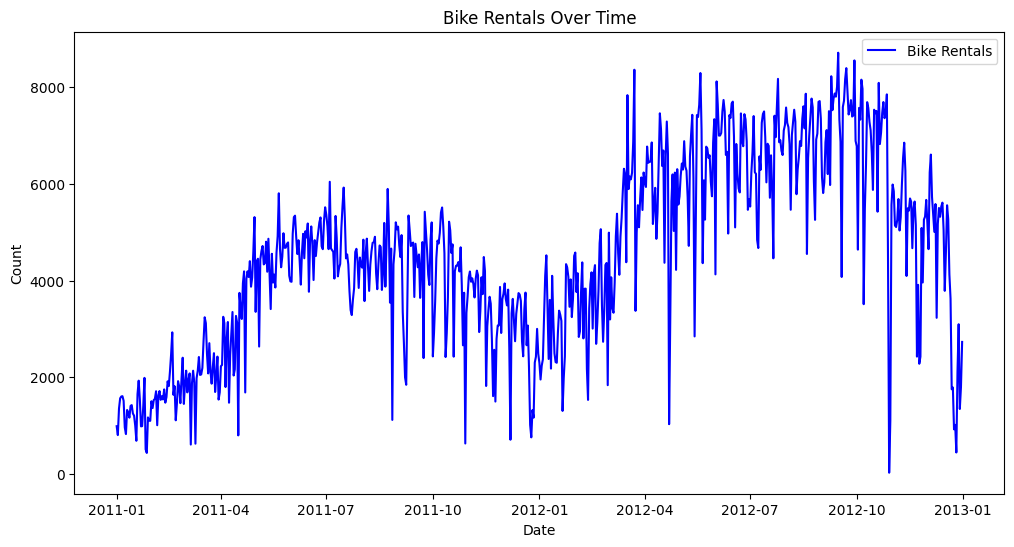

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['dteday'], df['cnt'], label='Bike Rentals', color='blue')
plt.title('Bike Rentals Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

#Clean up any outliers or missing values if needed

In [ ]:
print(df.isnull().sum())

df = df.dropna()


Q1 = df['cnt'].quantile(0.25)
Q3 = df['cnt'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['cnt'] >= Q1 - 1.5 * IQR) & (df['cnt'] <= Q3 + 1.5 * IQR)]

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
month         0
dtype: int64


#Smooth your time series and compare with the original

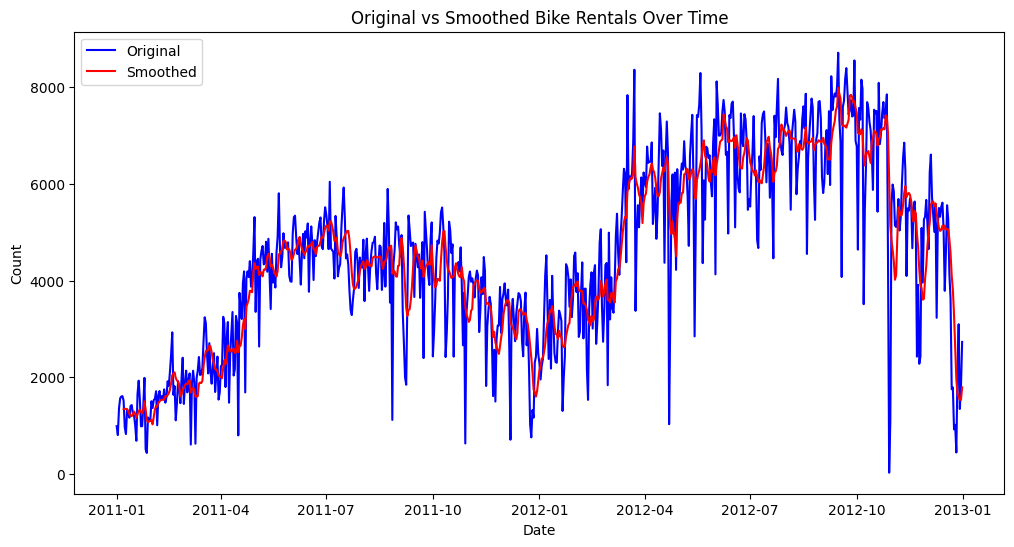

In [ ]:
df['cnt_smoothed'] = df['cnt'].rolling(window=7).mean()

plt.figure(figsize=(12, 6))
plt.plot(df['dteday'], df['cnt'], label='Original', color='blue')
plt.plot(df['dteday'], df['cnt_smoothed'], label='Smoothed', color='red')
plt.title('Original vs Smoothed Bike Rentals Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

#the Smoothing Method
In this project, I used a simple moving average as the smoothing method. This involves taking the average of a specified window of data points
Advantage: Simple moving averages are easy to understand and implement.

In [ ]:
df['cnt_smoothed'] = df['cnt'].rolling(window=7).mean()


#Adding the Frequency

In [ ]:
df = df.set_index(pd.DatetimeIndex(df['dteday']))

df = df.asfreq('D')


#Analyzing Stationarity and Seasonality
A time series is considered stationary if its statistical properties, such as mean and variance, remain constant over time.

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['cnt_smoothed'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -1.8279115152284042
p-value: 0.36669506993087997


Seasonality refers to patterns that repeat at regular intervals.


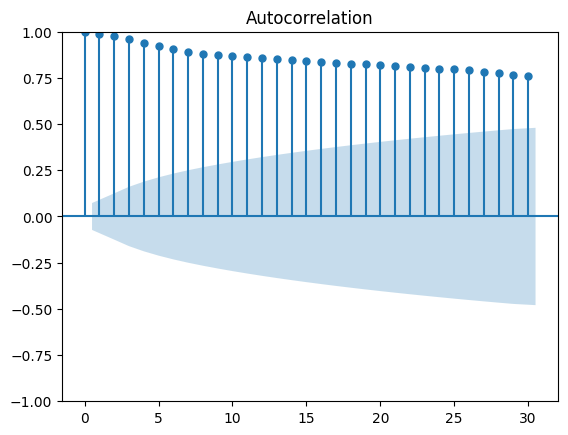

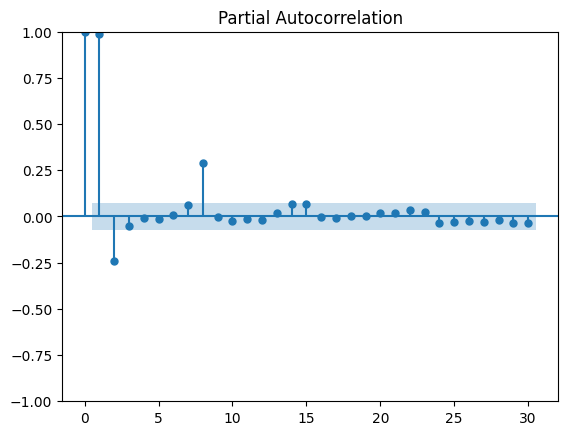

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF plots
plot_acf(df['cnt_smoothed'].dropna(), lags=30)
plot_pacf(df['cnt_smoothed'].dropna(), lags=30)
plt.show()


# Identify the Candidate Models:

ARIMA models are denoted as ARIMA(p, d, q), where:

p: The order of the autoregressive (AR) component.

d: The degree of differencing required to make the time series stationary.

q: The order of the moving average (MA) component.

ADF Statistic: -1.8279115152284042
p-value: 0.36669506993087997


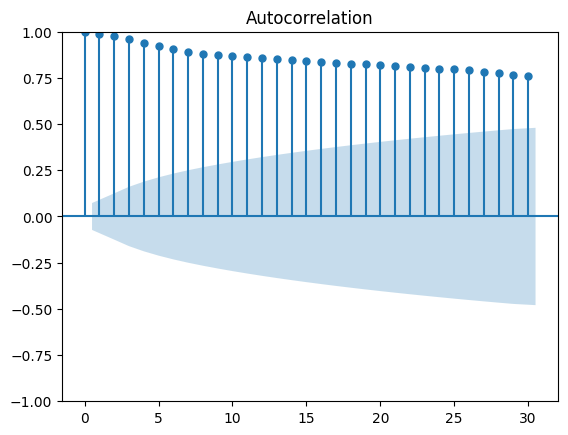

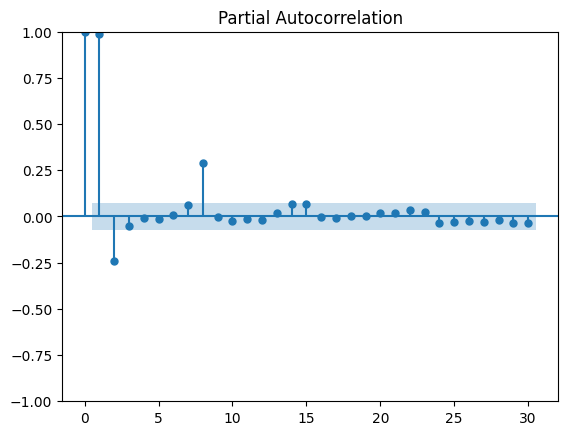

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

result = adfuller(df['cnt_smoothed'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

plot_acf(df['cnt_smoothed'].dropna(), lags=30)
plot_pacf(df['cnt_smoothed'].dropna(), lags=30)
plt.show()


#Model

Justification for Model Choice:

Model Performance: Consider metrics like AIC (Akaike Information Criterion) or BIC (Bayesian Information Criterion) provided in the model summary. Lower values of these criteria generally indicate a better-fitting model.

Diagnostic Checks: Examine the residuals of the model for any patterns or autocorrelation. Residuals should resemble white noise.

Interpretability: Choose a model that makes sense in the context of your data and provides interpretable results.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Define the values for p, d, and q
p = 1
d = 1
q = 1

model = ARIMA(df['cnt_smoothed'].dropna(), order=(p, d, q))
result = model.fit()

print(result.summary())


                               SARIMAX Results                                
Dep. Variable:           cnt_smoothed   No. Observations:                  725
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4781.291
Date:                Fri, 05 Jan 2024   AIC                           9568.582
Time:                        21:37:55   BIC                           9582.336
Sample:                    01-07-2011   HQIC                          9573.890
                         - 12-31-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4361      0.094      4.663      0.000       0.253       0.619
ma.L1         -0.0863      0.104     -0.833      0.405      -0.289       0.117
sigma2      3.206e+04   1017.240     31.516      0.0

#Remove Seasonality from the Time Series


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_decomposition = seasonal_decompose(df['cnt_smoothed'].dropna(), model='additive')

cnt_deseasonalized = df['cnt_smoothed'].dropna() - result_decomposition.seasonal



#Identify Candidate Models

ADF Statistic: -1.8293620064620586
p-value: 0.3659847583476996


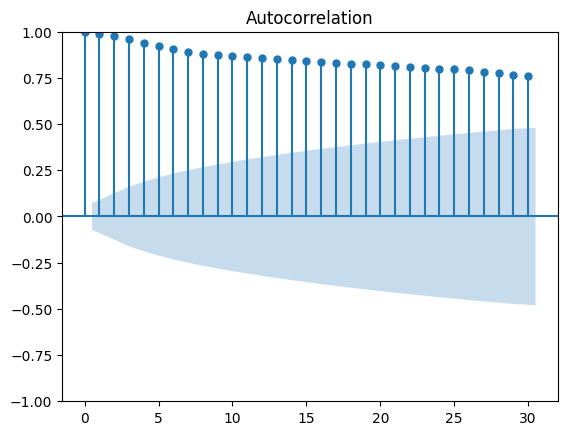

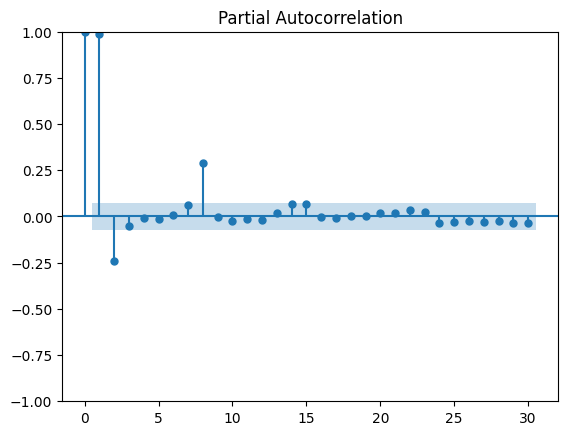

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

result_adf_deseasonalized = adfuller(cnt_deseasonalized)
print('ADF Statistic:', result_adf_deseasonalized[0])
print('p-value:', result_adf_deseasonalized[1])

plot_acf(cnt_deseasonalized, lags=30)
plot_pacf(cnt_deseasonalized, lags=30)
plt.show()


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

p_deseasonalized = 1
d_deseasonalized = 1
q_deseasonalized = 1

model_deseasonalized = ARIMA(cnt_deseasonalized, order=(p_deseasonalized, d_deseasonalized, q_deseasonalized))
result_deseasonalized = model_deseasonalized.fit()

print(result_deseasonalized.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  725
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4781.289
Date:                Fri, 05 Jan 2024   AIC                           9568.577
Time:                        21:43:15   BIC                           9582.332
Sample:                    01-07-2011   HQIC                          9573.886
                         - 12-31-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4361      0.093      4.667      0.000       0.253       0.619
ma.L1         -0.0863      0.104     -0.834      0.405      -0.289       0.117
sigma2      3.206e+04   1017.623     31.504      0.0

#Fit an ARIMA Model with Auto-ARIMA


In [ ]:
pip install pmdarima


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.6 MB/s eta 0:00:00


In [ ]:
import pmdarima as pm

model_autoarima = pm.auto_arima(cnt_deseasonalized, suppress_warnings=True, seasonal=False)

print(model_autoarima.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  725
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -4727.960
Date:                Fri, 05 Jan 2024   AIC                           9465.920
Time:                        22:09:19   BIC                           9488.844
Sample:                    01-07-2011   HQIC                          9474.768
                         - 12-31-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3147      0.030    -44.038      0.000      -1.373      -1.256
ar.L2         -0.4596      0.030    -15.455      0.000      -0.518      -0.401
ma.L1          1.7975      0.009    192.401      0.0

#Check Residuals and Conclusions

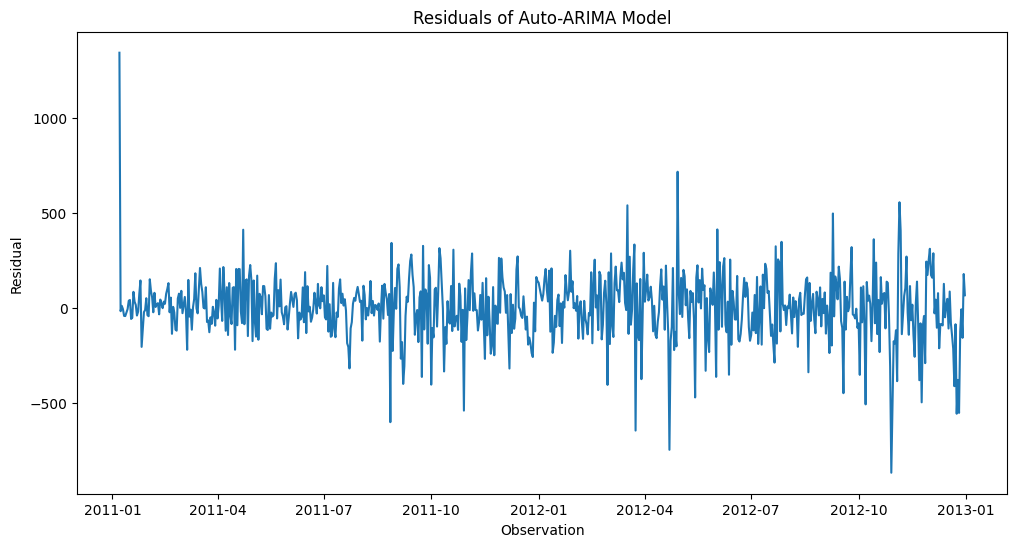

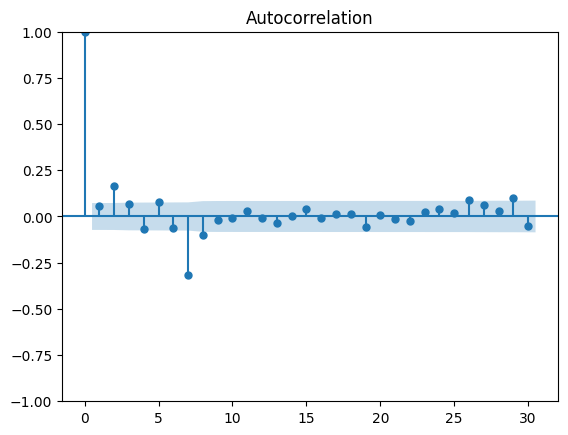

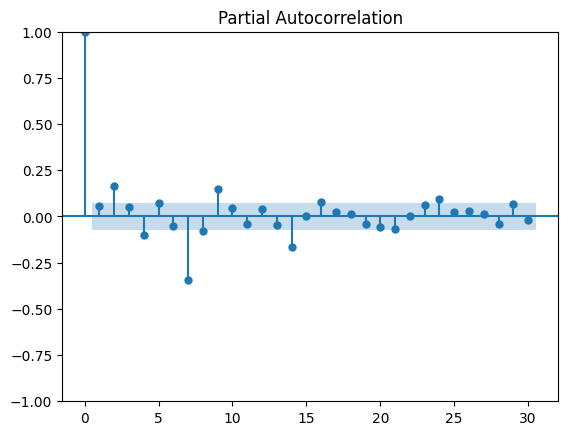

In [ ]:
# Get residuals
residuals = model_autoarima.resid()

plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuals of Auto-ARIMA Model')
plt.xlabel('Observation')
plt.ylabel('Residual')
plt.show()

plot_acf(residuals, lags=30)
plot_pacf(residuals, lags=30)
plt.show()


In [ ]:
from scipy.stats import normaltest

# Normality test on residuals
stat, p_value = normaltest(residuals)
print('Normality Test Statistic:', stat)
print('p-value:', p_value)


Normality Test Statistic: 113.08969075176098
p-value: 2.772590131914141e-25


Conclusion:
Model Adequacy:

The negative log likelihood (Log Likelihood) is -4727.960, indicating how well the model fits the data. Lower values are generally better.
AIC and BIC are measures of the model's goodness of fit and complexity. Lower values are preferred, but the choice between AIC and BIC depends on the context.
Diagnostic Tests:

A low p-value in the Ljung-Box test (Q) may suggest some remaining autocorrelation in the residuals.
The Jarque-Bera test indicates potential non-normality in the residuals.
The Heteroskedasticity test (H) suggests the presence of non-constant variance in the residuals.
Parameter Estimates:

The estimated coefficients for the AR and MA terms indicate the strength and direction of the relationships between the current observation and its past values.

#Visual Inspection of Residuals


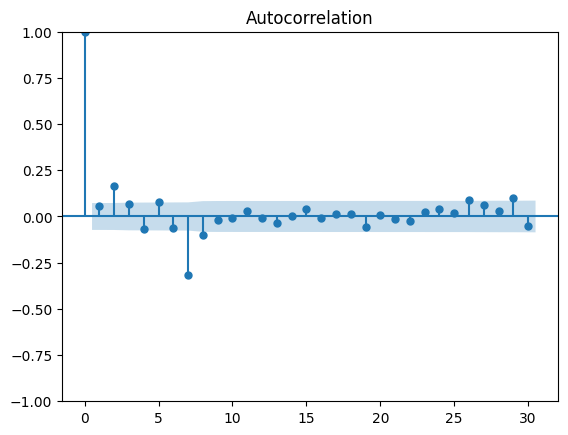

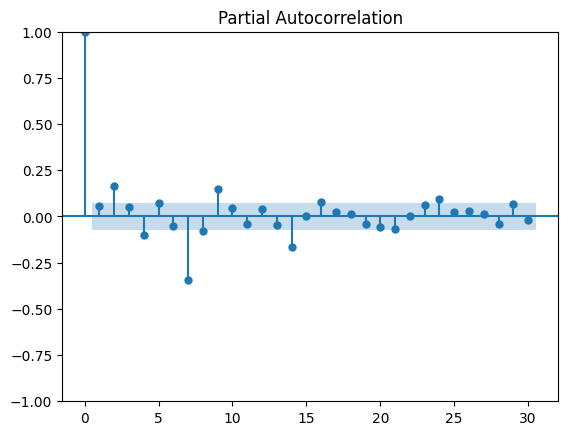

In [ ]:
plot_acf(model_autoarima.resid(), lags=30)
plot_pacf(model_autoarima.resid(), lags=30)
plt.show()


#Refit the Model

In [ ]:
P = 2
D = 1
Q = 2
m = 12

model_refined = SARIMAX(cnt_deseasonalized, order=(p, d, q), seasonal_order=(P, D, Q, m))
result_refined = model_refined.fit()

print(result_refined.summary())



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  725
Model:             SARIMAX(1, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood               -4722.690
Date:                                 Fri, 05 Jan 2024   AIC                           9459.381
Time:                                         22:18:15   BIC                           9491.357
Sample:                                     01-07-2011   HQIC                          9471.732
                                          - 12-31-2012                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4539      0.097      4.662      0.000       0.263       0

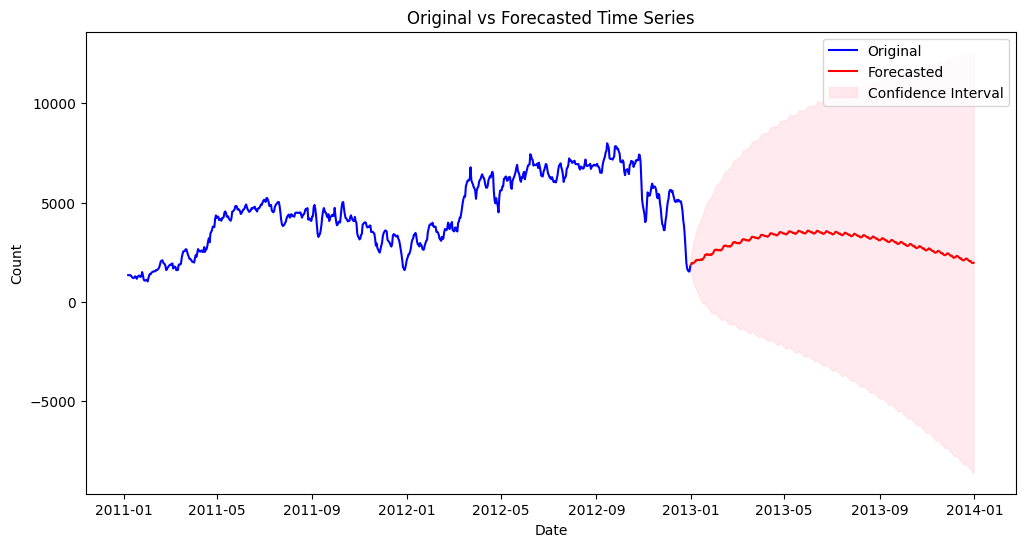

In [ ]:
# Forecast future values
forecast_steps = 365
forecast = result_refined.get_forecast(steps=forecast_steps)

forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(cnt_deseasonalized, label='Original', color='blue')
plt.plot(forecast_values, label='Forecasted', color='red')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
plt.title('Original vs Forecasted Time Series')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


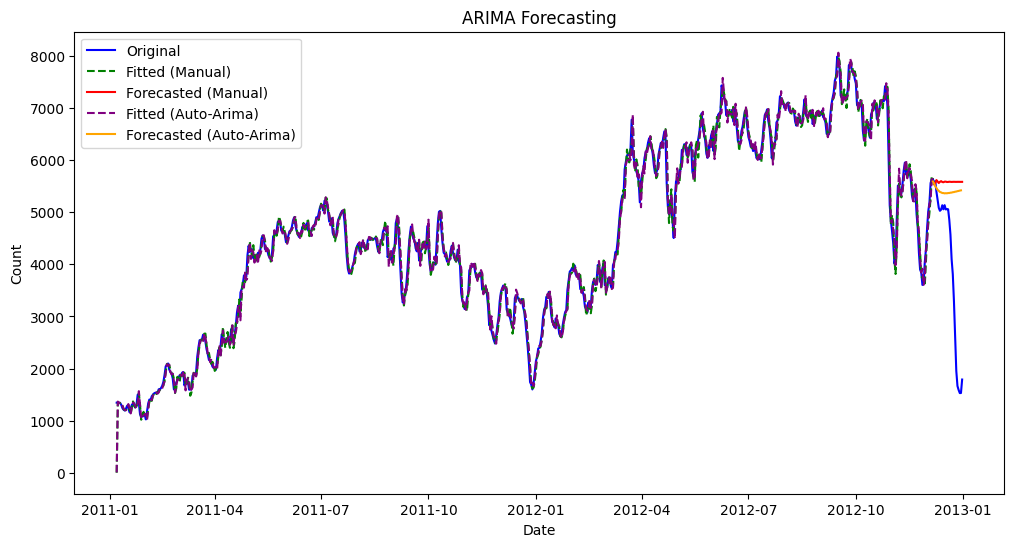

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm


train_data = cnt_deseasonalized[:700]
test_data = cnt_deseasonalized[700:]

# Fit an ARIMA model manually on the training set
p_manual, d_manual, q_manual = 2, 1, 2  # Replace with your chosen values
model_manual = ARIMA(train_data, order=(p_manual, d_manual, q_manual))
result_manual = model_manual.fit()

# Fit an ARIMA model with Auto-Arima on the training set
model_autoarima_train = pm.auto_arima(train_data, suppress_warnings=True, seasonal=False)

# Forecast the next 25 observations
forecast_steps = 25
forecast_manual = result_manual.get_forecast(steps=forecast_steps)
forecast_index_manual = pd.date_range(start=train_data.index[-1], periods=forecast_steps + 1, freq='D')[1:]

# Forecast the next 25 observations with Auto-Arima
forecast_autoarima_train = model_autoarima_train.predict(n_periods=forecast_steps)
forecast_index_autoarima = pd.date_range(start=train_data.index[-1], periods=forecast_steps, freq='D')

# Plot the original and forecasted time series
plt.figure(figsize=(12, 6))
plt.plot(cnt_deseasonalized, label='Original', color='blue')
plt.plot(train_data.index, result_manual.fittedvalues, label='Fitted (Manual)', color='green', linestyle='--')
plt.plot(forecast_index_manual, forecast_manual.predicted_mean, label='Forecasted (Manual)', color='red')

plt.plot(train_data.index, model_autoarima_train.predict_in_sample(), label='Fitted (Auto-Arima)', color='purple', linestyle='--')
plt.plot(forecast_index_autoarima, forecast_autoarima_train, label='Forecasted (Auto-Arima)', color='orange')

plt.title('ARIMA Forecasting')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()